# House Prices

dataset = "HPSSA dataset 37 - Media prices paid by ward.xls"

(HPSSA - House Price Statistics for Small Areas)


available from: https://www.ons.gov.uk/peoplepopulationandcommunity/housing/datasets/medianpricepaidbywardhpssadataset37


All Data used is freely available from ONS and is used under the Open Government Licence.

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from matplotlib import pyplot as plt

In [2]:
hpssa = pd.read_csv('median_HPSSA_37.csv')
hpssa = hpssa.replace(':', np.nan)

### Data prep


In [3]:
## Convert all columns into numeric for later analysis.
## Coming in it is assumed as string due to the presence of commas.
quarterly_columns = hpssa.columns[4:]
for column in quarterly_columns:
    hpssa[column] = hpssa[column].str.replace(',','')
    hpssa[column] = pd.to_numeric(hpssa[column]).astype('float32')

## Shortening the names of all time series columns for datetime conversion
conversion_dict = dict(zip(quarterly_columns,[string[-8:] for string in quarterly_columns]))
hpssa = hpssa.rename(columns = conversion_dict)
## Convert to datetime
hpssa.columns = hpssa.columns[:4].to_list() + pd.to_datetime(hpssa.columns[4:]).to_list()
quarterly_columns = hpssa.columns[4:]

In [4]:
## Only in england and wales
print('# authorities : ',len(hpssa['Local authority code'].unique()))
print('# wards : ', len(hpssa['Ward name'].unique()))

#now, must be some instances of double wards

# authorities :  336
# wards :  7479


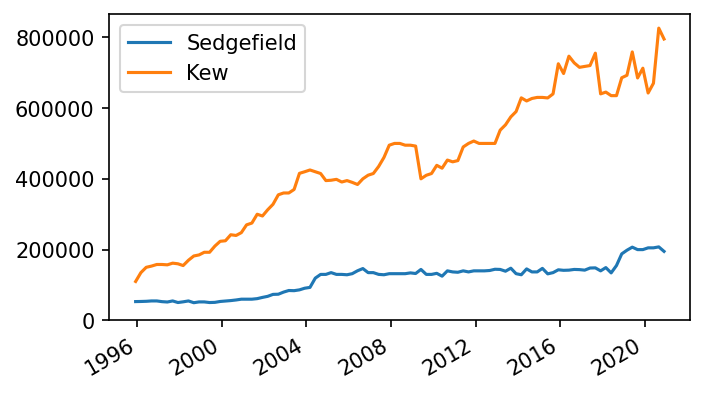

In [5]:
fig,ax = plt.subplots(dpi = 150,figsize = (5,3))
labels = ['Sedgefield','Kew']
hpssa[hpssa['Ward name'] == 'Sedgefield'][quarterly_columns].T.plot(ax = ax,label = 'Sedgefield',legend = None)
hpssa[hpssa['Ward code'] == 'E05000524'][quarterly_columns].T.plot(ax = ax,label = 'Kew',legend = None)
ax.set_ylim((0,None))
ax.legend(labels)

### Add Geodata

Geospatial data is added to enable visual plotting of the England and Wales region across desired metrics. 

The geodata is freely available from https://geoportal.statistics.gov.uk/datasets/ons::wards-december-2020-uk-bfc-v2/about


A subset of the original is used here, having cropped out all ward codes not in the hpssa dataset( ie, excluded Scotland and Northern Ireland) to reduce the file size sufficiently. 
geopandas is a python library that connects well with pandas and provides extra functionality for use with choropleth maps.

In [6]:
geodata = gpd.read_file('wards_dec2020.zip')
geodata = geodata[geodata['WD20CD'].isin(hpssa['Ward code'])]

SQL style inner join on the two dataframes:

In [7]:
merged = pd.merge(geodata,hpssa,left_on = 'WD20CD',right_on = 'Ward code')

## Drop redundant columns
merged = merged.drop(merged.columns[:7],axis = 1)

## Define area variable and local auth geometry
merged['area'] = merged.geometry.area
#%% timeit local_auth = merged[['Local authority name','Local authority code','geometry']].dissolve(by = 'Local authority code')

### Add Population

The hsspa Dataset can be combined with other regional data, the first being a **population** estimate of each ward.

https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/wardlevelmidyearpopulationestimatesexperimental

In [21]:
pop_ds = pd.read_csv('ward_pop_est.csv')

## Conversion to numeric
pop_ds = pop_ds.replace(':', np.nan)
pop_ds['All Ages'] = pd.to_numeric(pop_ds['All Ages'].str.replace(',',''))
print('# missing pop :',pop_ds['All Ages'].isna().sum().sum())

## Prepare for merge
pop_ds = pop_ds.rename({'Ward Code 1':'Ward code'},axis = 1)
pop_ds = pop_ds[['Ward code','All Ages']]

# missing pop ; 0


Population of  59.398537 million



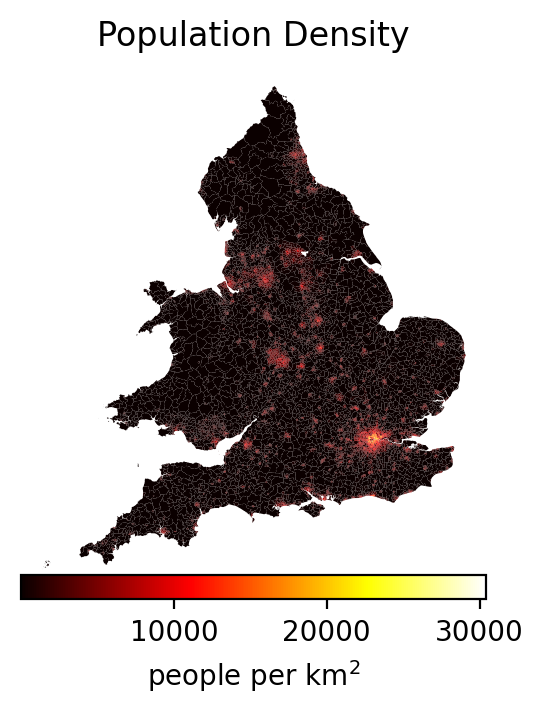

In [9]:
#Join
merged = pd.merge(merged,pop_ds,left_on = 'Ward code',right_on = 'Ward code')
#Area density estimate with conv to km^2
merged['Density'] = merged['All Ages'] / (merged.area / 1_000_000)

print('Population of ',merged['All Ages'].sum() * 1e-6, 'million')

fig,ax = plt.subplots(dpi = 200)
ax.set_title('Population Density')
merged.plot('Density',ax = ax,cmap = 'hot',legend = True, #inferno_r
            legend_kwds = {'label' : 'people per km$^2$',"orientation" : 'horizontal', "shrink" : 0.5,'pad': -0.03})
ax.axis('off')
print()

### Gross Salary


Also adding median **gross annual salaries** for full time employees, however this is only available for local authority, not ward.

Taken from Annual Survey of Hours and Earnings (ASHE)

Queried from https://www.nomisweb.co.uk/

> "#","These figures are suppressed as statistically unreliable"

> "!","Estimate and confidence interval not available since the group sample size"
"","is zero or disclosive (0-2)"

> "-","These figures are missing."

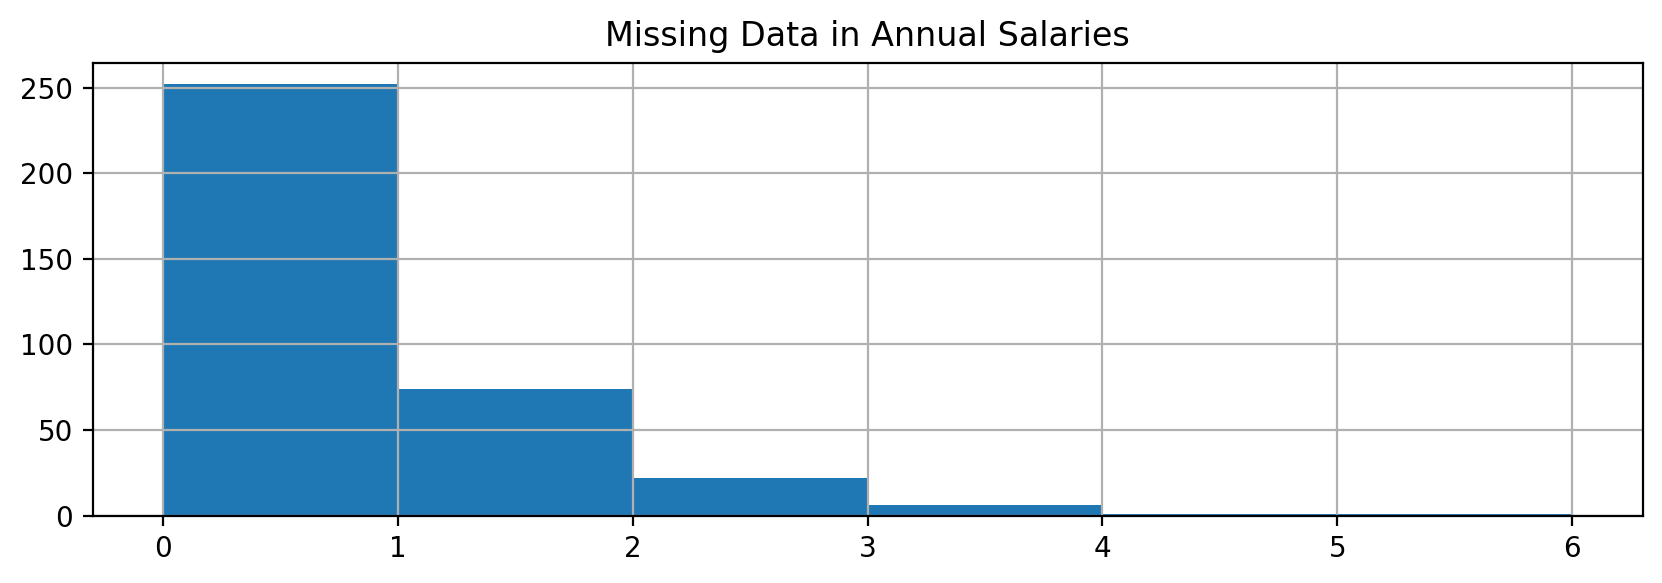

In [10]:
pay_ds = pd.read_csv('gross_annual_salary.csv')
pay_ds.columns = pay_ds.loc[0]
pay_ds = pay_ds.loc[3:]
pay_ds = pay_ds.reset_index()
pay_ds = pay_ds.drop(columns = 'index')

temp = pay_ds[pay_ds.columns[2:]].to_numpy()

## Removing rows with '-' and '!'
drop_inds = np.append(np.unique(np.where(temp == '-')[0]),np.unique(np.where(temp == '!')[0]))
pay_ds = pay_ds.drop(drop_inds)

## Replace '#' with np.nan and convert to numeric
pay_ds = pay_ds.replace({'#' : np.nan})
pay_ds[pay_ds.columns[2:]] = pay_ds[pay_ds.columns[2:]].apply(pd.to_numeric)

plt.figure(dpi = 200,figsize = (10,3))
pay_ds.isna().sum(axis = 1).hist(bins = 6)
plt.title('Missing Data in Annual Salaries')
print()

In [11]:
## Removing those with 3 or more missing years
pay_ds = pay_ds[pay_ds.isna().sum(axis = 1) <= 2]
pay_ds.columns = pay_ds.columns[:2].to_list() + pd.to_datetime(pay_ds.columns[2:]).to_list()

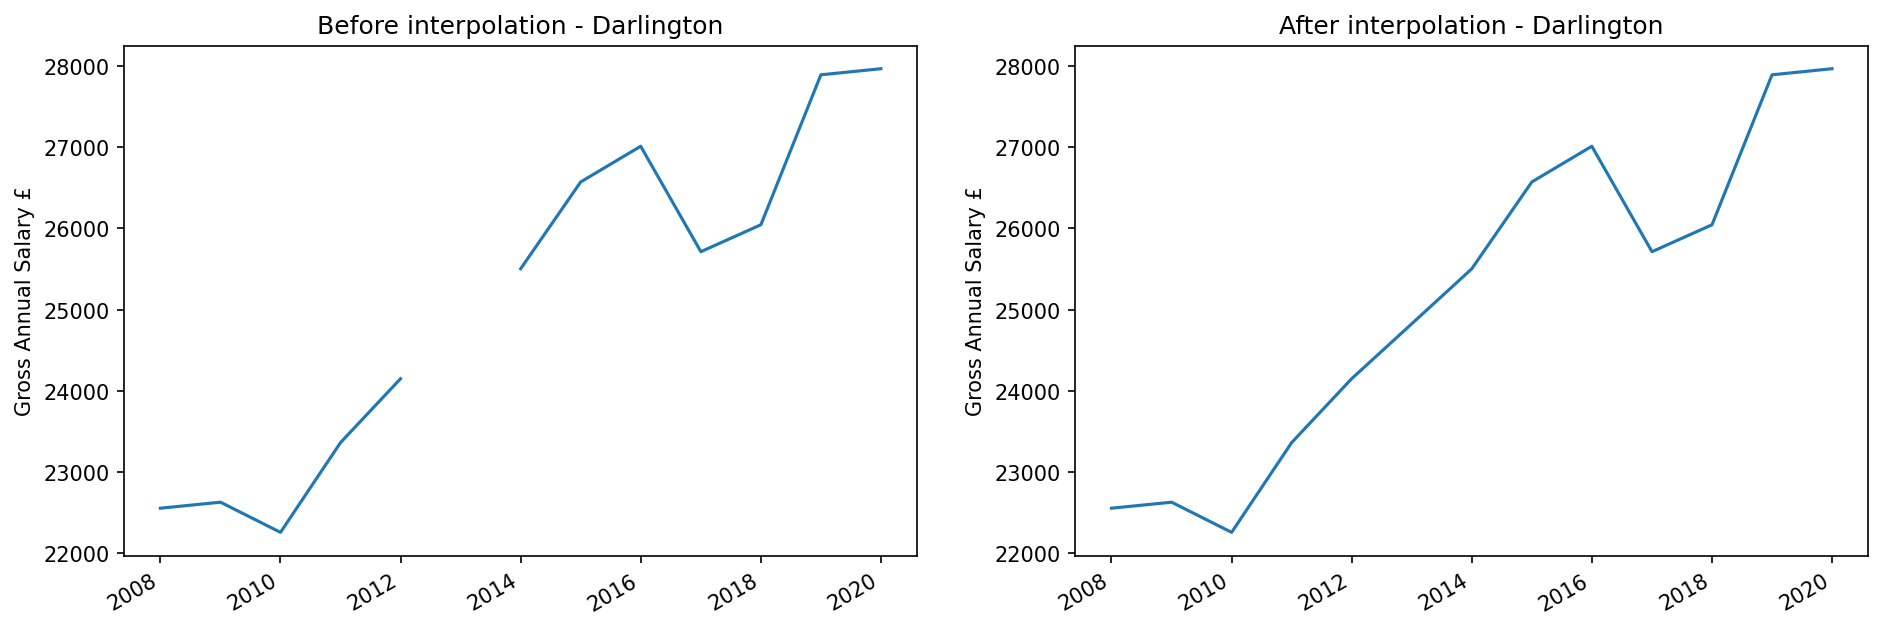

In [12]:
fig,ax = plt.subplots(ncols = 2,dpi = 150,figsize = (15,5))

## interpolate the rest of the missing values
pay_ds.loc[0][pay_ds.columns[2:]].plot(ax = ax[0],
                                      title = 'Before interpolation - ' + str(pay_ds.loc[0]['Area'])[5:],
                                         ylabel = 'Gross Annual Salary £') #before
pay_ds[pay_ds.columns[2:]] = pay_ds[pay_ds.columns[2:]].interpolate(method = 'linear',axis = 1) # also 'from_derivatives'
pay_ds.loc[0][pay_ds.columns[2:]].plot(ax = ax[1],
                                         title = 'After interpolation - ' + str(pay_ds.loc[0]['Area'])[5:],
                                         ylabel = 'Gross Annual Salary £') #after
print()

###  Missing values - House Prices

In [13]:
merged['missing'] = merged[quarterly_columns].isna().any(axis =1)
print('# missing values :',merged.isna().sum().sum())
print('# missing values in time series :',merged[quarterly_columns].isna().sum().sum())

# missing values : 1347
# missing values in time series : 1347


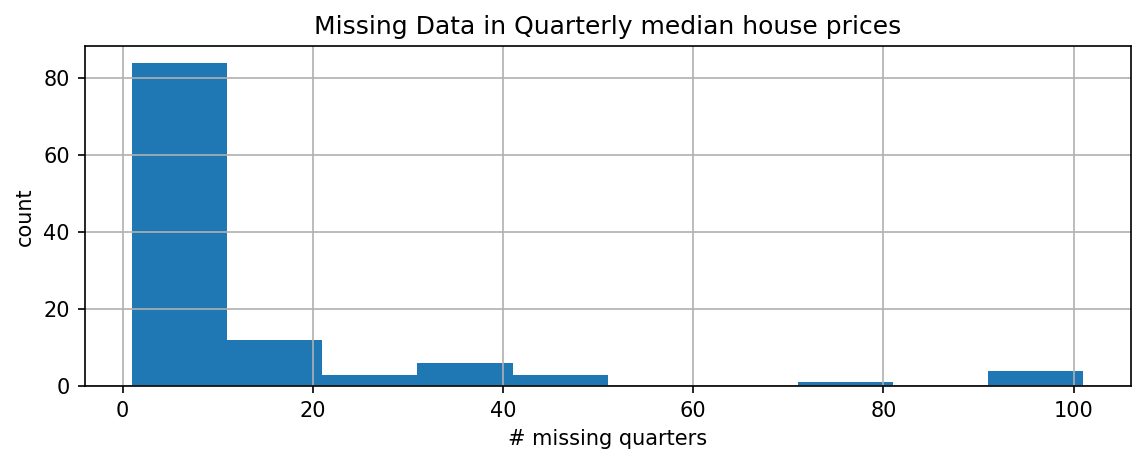

In [14]:
plt.figure(dpi = 150,figsize = (9,3))
merged[merged[quarterly_columns].isna().sum(axis = 1) > 0][quarterly_columns].isna().sum(axis = 1).hist()
plt.xlabel('# missing quarters')
plt.ylabel('count')
plt.title('Missing Data in Quarterly median house prices')
print()

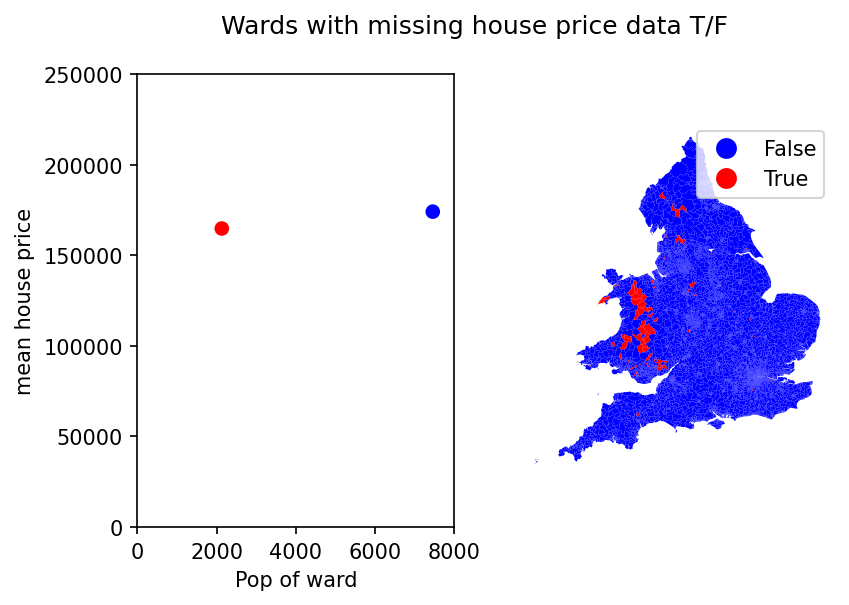

In [15]:
fig,ax = plt.subplots(dpi = 150,nrows = 1,ncols = 2)
merged.plot('missing',ax = ax[1],categorical = True,legend = True,cmap = 'bwr')

gb = merged.groupby('missing').mean()
ax[0].scatter(gb['All Ages'],gb[quarterly_columns].mean(axis = 1),c = gb.index,cmap = 'bwr')
ax[0].set_ylim((0,250_000))
ax[0].set_xlim((0,8000))
ax[0].set_ylabel('mean house price')
ax[0].set_xlabel('Pop of ward')
ax[1].axis('off')
fig.suptitle('Wards with missing house price data T/F')
print()

Some wards have no time series data for house prices, and so are removed. The single instance with over 50 missing values is also removed, all else can be interpolated appropriately.

Wards with missing time series values, (which have some price data available), are substantially less populous and insignificantly marginally less expensive.

# missing any time series : 29



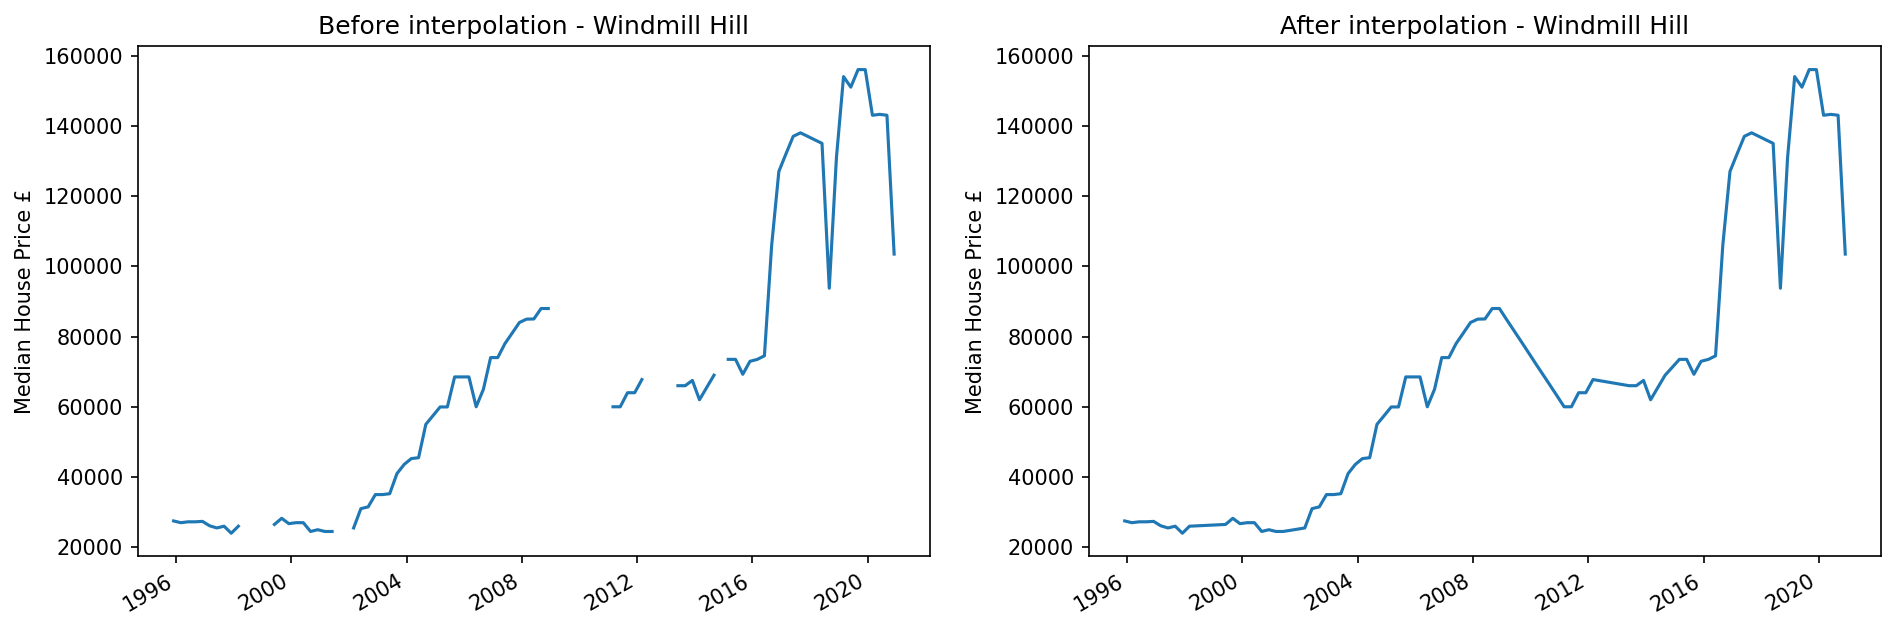

In [16]:
example_n = 1135

## remove instances with many (>50) missing values
merged = merged.drop(merged[merged[quarterly_columns].isna().sum(axis = 1) > 50].index)

fig,ax = plt.subplots(ncols = 2,dpi = 150,figsize = (15,5))

## interpolate the rest of the missing values
merged.loc[example_n][quarterly_columns].plot(ax = ax[0],
                                        title = 'Before interpolation - ' + str(merged.loc[example_n]['Ward name']),
                                         ylabel = 'Median House Price £') #before
merged[quarterly_columns] = merged[quarterly_columns].interpolate(method = 'linear',axis = 1) # also 'from_derivatives'
merged.loc[example_n][quarterly_columns].plot(ax = ax[1],
                                        title = 'After interpolation - ' + str(merged.loc[example_n]['Ward name']),
                                         ylabel = 'Median House Price £') #after

## check
print('# missing any time series :',len(merged[merged[quarterly_columns].isna().sum(axis = 1) > 0]))
print()

## Adjust for inflation

https://www.ons.gov.uk/economy/inflationandpriceindices/datasets/consumerpriceindices

Using column : **CPI INDEX 00: ALL ITEMS 2015=100**

Therefore all prices are relative to pricing in 2015

In [17]:
inflation = pd.read_csv('cpi_quarterly.csv')
## drop redundant col
inflation = inflation.drop(columns = inflation.columns[0])
## change for change to dt
inflation.Title = inflation.Title.str.replace(' ','-')

In [18]:
## convert to dt and go back a month to align correctly
inflation = inflation.set_index(pd.PeriodIndex(inflation.Title,freq = 'Q').to_timestamp() - pd.DateOffset(months=1))
inflation = inflation.drop(columns = inflation.columns[0])
inflation.index = inflation.index.rename('Year')

In [19]:
inflation.loc[quarterly_columns].head()

,CPI INDEX 00: ALL ITEMS 2015=100
Year,
1995-12-01,68.1
1996-03-01,68.9
1996-06-01,68.9
1996-09-01,69.4
1996-12-01,69.4


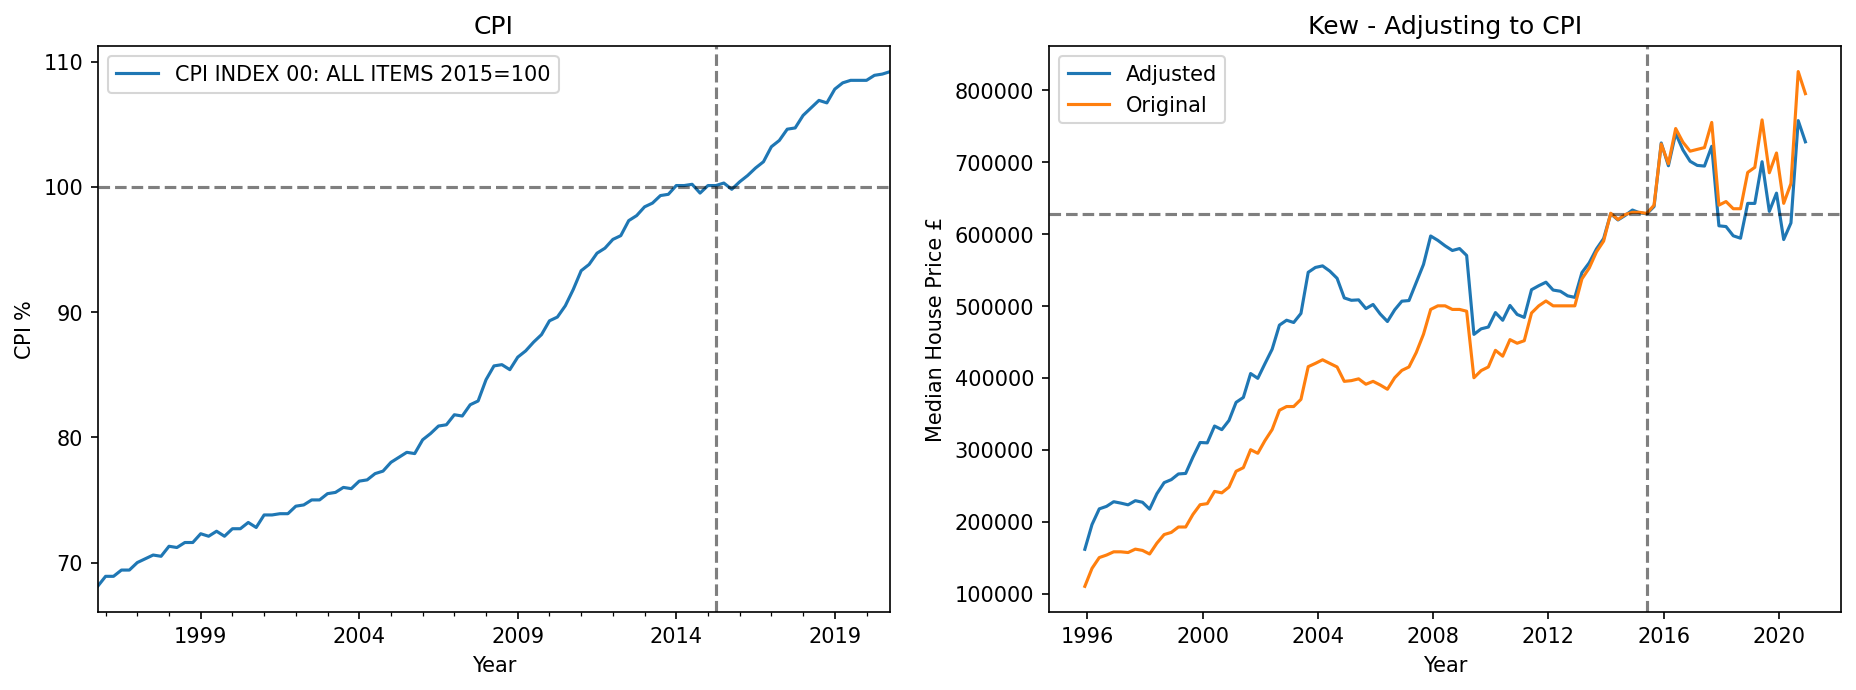

In [20]:
example_ward = 'Kew'
ward_index = merged[merged['Ward name'] == example_ward].index[0]
rel_time = inflation.index[108]

fig,ax = plt.subplots(nrows = 1,ncols = 2,dpi = 150,figsize = (15,5))
inflation.loc[quarterly_columns].plot(ax = ax[0])
ax[0].axhline(y = 100,ls = '--',c = 'black',alpha = 0.5)
ax[0].axvline(x = rel_time,ls = '--',c = 'black',alpha = 0.5)
ax[0].set_title('CPI')
ax[0].set_ylabel('CPI $\%$')

## divide by inflation % and times by 100
temp = (merged[quarterly_columns].values / inflation.loc[quarterly_columns].values[:,0]) * 100

ax[1].plot(quarterly_columns,temp[ward_index,:],label = 'Adjusted')
ax[1].plot(quarterly_columns,merged[quarterly_columns].values[ward_index,:],label = 'Original')
ax[1].axvline(x = rel_time,ls = '--',c = 'black',alpha = 0.5)
ax[1].axhline(y = temp[ward_index,78],ls = '--',c = 'black',alpha = 0.5)
ax[1].legend()
ax[1].set_title(example_ward + ' - Adjusting to CPI')
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Median House Price £')
print()